In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
_FOLDER = "../data/"
from sklearn.ensemble import BaggingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.multioutput import MultiOutputRegressor
## autoML

import json

In [2]:
def createResponseCurve(iD,model, xValues, yValues, predicted = False):
#     fig = plt.figure(figsize=(5, 5))
    plt.scatter(xValues, yValues)
    plt.title(model + " " + iD)
    plt.xlabel("Scaled dosage")
    if(predicted):
        plt.ylabel("Predicted Normalised response")
    else:
        plt.ylabel("Normalised response")
    plt.show()


with open(_FOLDER + 'dataSplit.json') as json_file:
    trainTestSplit = json.load(json_file)

In [3]:
drugProfiles = pd.read_csv(_FOLDER+'filteredResponsesWithCCLAndParams.csv')
drugProfiles

,CELL_LINE_NAME,COSMIC_ID,DRUG_ID,DRUGID_COSMICID,MAX_CONC,fd_num_0,fd_num_1,fd_num_2,fd_num_3,fd_num_4,...,chr9:104248247-104249501(C9orf125)_HypMET,"chr9:115875199-115875738(C9orf109, C9orf110)_HypMET",chr9:123555399-123555899(FBXW2)_HypMET,chr9:140310894-140312457(EXD3)_HypMET,chr9:21974578-21975306(CDKN2A)_HypMET,chr9:35756948-35757339(MSMP)_HypMET,chr9:35791584-35791924(NPR2)_HypMET,chr9:4984543-4985630(JAK2)_HypMET,chr9:86571047-86572027(C9orf64)_HypMET,chr9:98783216-98784364(NCRNA00092)_HypMET
0,HDQ-P1,1290922,344,344_1290922,20.00,0,0.111111,0.222222,0.333333,0.444444,...,0,0,0,0,0,0,0,0,0,0
1,HDQ-P1,1290922,136,136_1290922,16.00,0,0.111111,0.222222,0.333333,0.444444,...,0,0,0,0,0,0,0,0,0,0
2,HDQ-P1,1290922,170,170_1290922,16.00,0,0.111111,0.222222,0.333333,0.444444,...,0,0,0,0,0,0,0,0,0,0
3,NMC-G1,908449,170,170_908449,16.00,0,0.111111,0.222222,0.333333,0.444444,...,0,0,0,0,0,0,0,0,1,0
4,NMC-G1,908449,331,331_908449,10.24,0,0.111111,0.222222,0.333333,0.444444,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5579,TC-YIK,946357,1011,1011_946357,2.00,0,0.111111,0.222222,0.333333,0.444444,...,0,0,0,0,0,0,0,0,0,0
5580,MKN45,925340,1149,1149_925340,5.00,0,0.111111,0.222222,0.333333,0.444444,...,0,0,0,0,0,0,0,0,0,0
5581,EC-GI-10,753555,1004,1004_753555,0.10,0,0.111111,0.222222,0.333333,0.444444,...,0,0,0,0,0,0,0,0,0,0
5582,IGROV-1,905968,1031,1031_905968,0.20,0,0.111111,0.222222,0.333333,0.444444,...,0,0,0,0,0,0,0,0,0,0


In [4]:
len(trainTestSplit.keys())

88

In [7]:
notIncludeColumns = ['CELL_LINE_NAME', 'COSMIC_ID', 'DRUG_ID', 'DRUGID_COSMICID','MAX_CONC'] + ['param_1', 'param_2','param_3','param_4']
conc_labels = ["fd_num_"+str(i) for i in range(10)]
resp_labels = ['norm_cells_'+str(i) for i in range(10)]
pred_resp_labels = ['pred_norm_cells_'+str(i) for i in range(10)]
fullPredLabels = ['DRUG_COSMICID'] + pred_resp_labels

predictedResults = pd.DataFrame(columns=fullPredLabels)
trueResults = pd.DataFrame(columns= ['DRUG_COSMICID']+ resp_labels)

drugId = 344

drugProfile = drugProfiles[drugProfiles['DRUG_ID'] == int(drugId)]
trainData = drugProfile[drugProfile['DRUGID_COSMICID'].isin(trainTestSplit[str(drugId)][0])]
testData = drugProfile[drugProfile['DRUGID_COSMICID'].isin(trainTestSplit[str(drugId)][1])]
testDataCosmicIds = np.array(testData['DRUGID_COSMICID'])
notXValuesFilter = resp_labels + notIncludeColumns + conc_labels
trainXValues = trainData.drop(columns = notXValuesFilter)
trainYValues = trainData[resp_labels]

trainX = trainXValues.reset_index(drop=True).to_numpy()
trainY = trainYValues.reset_index(drop=True).to_numpy()

testXValues = testData.drop(columns = notXValuesFilter)
testYValues = testData[resp_labels]

testX = testXValues.reset_index(drop=True).to_numpy()
testY = testYValues.reset_index(drop=True).to_numpy()

n_estimators = 5
svm_bagging = MultiOutputRegressor(BaggingRegressor(base_estimator=SVR(kernel='sigmoid', C=1), n_estimators=n_estimators))
svm_bagging.fit(trainX, trainY)

yTrainPredict = svm_bagging.predict(trainX)
yTestPredict = svm_bagging.predict(testX)

test_mse = mean_squared_error(yTrainPredict, trainY)
trueResult = pd.DataFrame(testDataCosmicIds, columns=['DRUG_COSMICID'])
trueResult[resp_labels] = testY
trueResults = trueResults.append(trueResult,ignore_index=True,sort=False)
result = pd.DataFrame(testDataCosmicIds, columns=['DRUG_COSMICID'])
result[pred_resp_labels] = yTestPredict
predictedResults = predictedResults.append(result,ignore_index=True,sort=False)

In [8]:
trueResults

,DRUG_COSMICID,norm_cells_0,norm_cells_1,norm_cells_2,norm_cells_3,norm_cells_4,norm_cells_5,norm_cells_6,norm_cells_7,norm_cells_8,norm_cells_9
0,344_910851,1.0,0.971586,0.906044,0.954482,0.917586,0.279158,0.258352,0.233342,0.204716,0.197107
1,344_717431,1.0,1.037550,1.091360,1.143341,1.097121,0.947674,0.659068,0.011337,0.015206,0.015280
2,344_910925,1.0,1.029277,1.108623,0.851732,0.782264,0.013142,0.003812,0.004973,0.006074,0.007326
3,344_908457,1.0,1.013743,1.001765,0.947623,0.911589,0.695498,0.440803,0.173345,0.013123,0.009104
4,344_910853,1.0,0.951634,0.922052,0.687362,0.582085,0.006510,0.004951,0.006649,0.003550,0.003617
5,344_908123,1.0,0.967067,0.945210,0.987415,0.996366,0.913169,0.745015,0.009191,0.005302,0.006474
6,344_905962,1.0,1.005736,0.992808,0.995439,0.973973,0.444915,0.193558,0.004517,0.005456,0.002408
7,344_722045,1.0,0.968492,0.976498,0.898752,0.746105,0.180655,0.086766,0.020786,0.006432,0.006455
8,344_917486,1.0,0.986723,0.914477,1.061182,0.754083,0.253797,0.016887,0.008990,0.010619,0.008801
9,344_906826,1.0,1.000641,1.065012,1.057747,0.963716,0.457469,0.286658,0.260749,0.062882,0.024845


In [9]:
predictedResults

,DRUG_COSMICID,pred_norm_cells_0,pred_norm_cells_1,pred_norm_cells_2,pred_norm_cells_3,pred_norm_cells_4,pred_norm_cells_5,pred_norm_cells_6,pred_norm_cells_7,pred_norm_cells_8,pred_norm_cells_9
0,344_910851,1.0,1.000704,0.931109,0.951564,0.828626,0.661744,0.222648,0.135616,0.036665,0.035015
1,344_717431,1.0,1.000704,0.885978,0.765200,0.679970,0.495315,0.190191,0.065862,0.036687,0.035015
2,344_910925,1.0,1.000704,1.000190,0.902871,0.909391,0.749445,0.293380,0.200747,0.036665,0.035015
3,344_908457,1.0,1.000704,0.969103,0.980346,0.853463,0.352385,0.045477,-0.048334,0.036665,0.035015
4,344_910853,1.0,1.000704,1.023000,1.043374,0.927584,0.941988,0.750156,0.396598,0.036708,0.035015
5,344_908123,1.0,1.000704,0.912226,0.900052,0.777295,0.491953,0.210887,0.020319,0.036730,0.035015
6,344_905962,1.0,1.000704,1.074109,1.080503,1.047360,0.415661,0.179391,-0.189660,0.036686,0.035015
7,344_722045,1.0,1.000704,0.991327,1.050605,0.818804,0.388202,0.152451,0.315139,0.036665,0.035015
8,344_917486,1.0,1.000704,0.965821,1.034617,0.834834,0.733957,0.374372,-0.048493,0.036665,0.035015
9,344_906826,1.0,1.000704,0.992389,1.013502,1.057621,0.822469,0.667290,0.056356,0.036708,0.035015


In [20]:
def showTestPredResponses(drugIdCosmic):
    samplePredicted = predictedResults[predictedResults['DRUG_COSMICID'] == drugIdCosmic].iloc[0:1,:]
    predictedY = samplePredicted[pred_resp_labels]
    trueY = trueResults[trueResults['DRUG_COSMICID'] == drugIdCosmic].iloc[0:1,:]
    xValues = [0, 0.111111111, 0.222222222, 0.333333333, 0.444444444, 0.555555556, 0.666666667, 0.777777778, 0.888888889, 1]
    trueY = trueY[resp_labels]
    plt.title(drugIdCosmic + " dosage against response")
    plt.scatter(xValues, predictedY, color='b', label='Predicted')
    plt.scatter(xValues, trueY, color='y', label='True')
    plt.xlabel("Scaled dosage")
    plt.ylabel("Normalised response")
    plt.show()

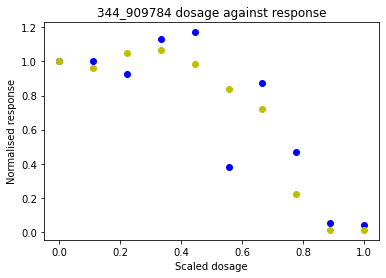

In [21]:
showTestPredResponses('344_909784')

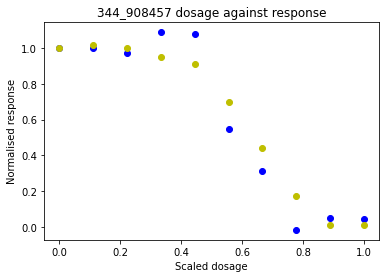

In [22]:
showTestPredResponses('344_908457')

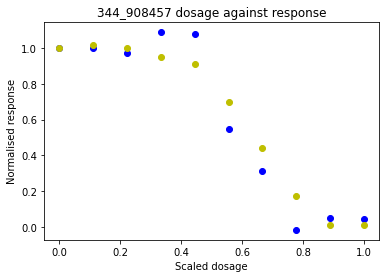

In [23]:
showTestPredResponses('344_908457')

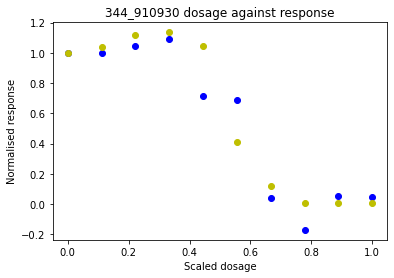

In [24]:
showTestPredResponses('344_910930')